In [1]:
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
def auto_spearman(df, verbose=True):

    metrics = list(df.columns)
    count = 1

    if verbose:
        print("""(Part 1) Automatically select non-correlated metrics based
            on a Spearman rank correlation test""")
    corrmat = df.corr(method='spearman')
    abs_corrmat = abs(corrmat)
    while True:
        # Identify correlated metrics with the correlation threshold of 0.7
        highly_correl_metrics = (abs_corrmat>0.7) & (abs_corrmat != 1)
        if highly_correl_metrics.any().any():
            # Find the strongest pair-wise correlation
            find_top_corr = pd.melt(abs_corrmat, ignore_index=False)
            find_top_corr.reset_index(inplace=True)
            find_top_corr = find_top_corr[find_top_corr['value'] != 1]
            top_corr_idx  = find_top_corr['value'].idxmax()
            top_corr_value = find_top_corr.loc[top_corr_idx, 'value']
            top_corr_i = find_top_corr.loc[top_corr_idx, :]

            # Get the 2 correlated metrics with the strongest correlation
            correl_metric_1 = top_corr_i[0]
            correl_metric_2 = top_corr_i[1]
            if verbose:
                print('Step', count,'comparing ', correl_metric_1, 
                    'and', correl_metric_2, ' with correl ', np.round(top_corr_value, 3))
            
            # Compute their correlation with other metrics outside of the pair
            correl_with_others_1 = np.mean(abs_corrmat[correl_metric_1]\
                                    [[i for i in metrics if i not in [correl_metric_1, correl_metric_2]]])
            correl_with_others_2 = np.mean(abs_corrmat[correl_metric_2]\
                                    [[i for i in metrics if i not in [correl_metric_1, correl_metric_2]]])
            if verbose:
                print('>', correl_metric_1, 'has average correl of', np.round(correl_with_others_1, 3), 'with other metrics')
                print('>', correl_metric_2, 'has average correl of', np.round(correl_with_others_2, 3), 'with other metrics')
            # Select the metric that shares the least correlation outside of the pair and exclude the other
            if correl_with_others_1 < correl_with_others_2:
                exclude_metric = correl_metric_2
            else:
                exclude_metric = correl_metric_1
            if verbose:
                print('>', 'Exclude', exclude_metric)
            count = count + 1
            metrics.remove(exclude_metric)
            abs_corrmat = abs_corrmat.loc[metrics, metrics]
        else:
            break
    if verbose:
        print('Part 1 of AutoSpearman,', metrics, 'are selected.')
    df = df.loc[:, metrics]

    # Prepare a dataframe for VIF
    df = add_constant(df)
    count = 1
    # (Part 2) Automatically select non-correlated metrics based on a Variance Inflation Factor analysis.
    if verbose:
        print('(Part 2) Automatically select non-correlated metrics based on a Variance Inflation Factor analysis')
    while True:
        # Calculate VIF scores
        vif_scores = pd.DataFrame([variance_inflation_factor(df.values, i) 
                                for i in range(df.shape[1])], index=df.columns)
        # Prepare a final dataframe of VIF scores
        vif_scores.reset_index(inplace=True)
        vif_scores.columns = ['Feature', 'VIFscore']
        vif_scores = vif_scores.loc[vif_scores['Feature'] != 'const', :]
        vif_scores.sort_values(by = ['VIFscore'], ascending=False, inplace=True)
        
        # Find features that have their VIF scores of above 5.0
        filtered_vif_scores = vif_scores[vif_scores['VIFscore'] >= 5.0]
        
        # Terminate when there is no features with the VIF scores of above 5.0
        if len(filtered_vif_scores) == 0:
            break
            
        # exclude the metric with the highest VIF score
        metric_to_exclude = list(filtered_vif_scores['Feature'].head(1))[0]
        if verbose:
            print('Step', count,'- exclude', str(metric_to_exclude))
        count = count + 1

        metrics.remove(metric_to_exclude)
        df = df.loc[:, metrics]

    if verbose:
        print('Part 2 of AutoSpearman,', metrics,'are selected.')

    return df


In [2]:
import pandas as pd
import numpy as np
data = pd.read_csv('/Users/saumenduroy/Documents/PhD Life/Explainability + SOAR/Explainers code/Best datset_model perspective_AUC/Data/lucene-3.1.csv')
data = data.drop('File', axis=1)
auto_spearman(data)

(Part 1) Automatically select non-correlated metrics based
            on a Spearman rank correlation test
Step 1 comparing  MAJOR_COMMIT and DDEV  with correl  1.0
> MAJOR_COMMIT has average correl of 0.233 with other metrics
> DDEV has average correl of 0.233 with other metrics
> Exclude DDEV
Step 2 comparing  RealBugCount and RealBug  with correl  1.0
> RealBugCount has average correl of 0.116 with other metrics
> RealBug has average correl of 0.115 with other metrics
> Exclude RealBugCount
Step 3 comparing  HeuBugCount and HeuBug  with correl  0.998
> HeuBugCount has average correl of 0.185 with other metrics
> HeuBug has average correl of 0.18 with other metrics
> Exclude HeuBugCount
Step 4 comparing  CountDeclMethod and CountDeclFunction  with correl  0.997
> CountDeclMethod has average correl of 0.438 with other metrics
> CountDeclFunction has average correl of 0.438 with other metrics
> Exclude CountDeclMethod
Step 5 comparing  SumCyclomatic and SumCyclomaticStrict  with correl

/Users/saumenduroy/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [3]:
## Load Data and preparing datasets

# Import for Load Data
from os import listdir
from os.path import isfile, join
import pandas as pd

# Import for Split Data into Training and Testing Samples
from sklearn.model_selection import train_test_split

train_dataset = pd.read_csv(('/Users/saumenduroy/Documents/PhD Life/Explainability + SOAR/Explainers code/Best datset_model perspective_AUC/Data/lucene-2.9.0.csv'), index_col = 'File')
test_dataset = pd.read_csv(('/Users/saumenduroy/Documents/PhD Life/Explainability + SOAR/Explainers code/Best datset_model perspective_AUC/Data/lucene-3.1.csv'), index_col = 'File')



outcome = 'RealBug'
features = ['CountDeclMethodPrivate', 'CountDeclMethodDefault', 'AvgEssential','CountDeclClassVariable', 'CountDeclClassMethod', 'AvgLineComment', 'CountLineComment', 'CountDeclClass', 'CountDeclMethodProtected', 'CountDeclInstanceVariable']
#outcome = 'RealBug'
#features = ['OWN_COMMIT', 'CountClassCoupled', 'AvgLine', 'RatioCommentToCode']
# OWN_COMMIT - # code ownership
# Added lines - # of added lines of code
# Count class coupled - # of classes that interact or couple with the class of interest
# RatioCommentToCode - The ratio of lines of comments to lines of code

# process outcome to 0 and 1
train_dataset[outcome] = pd.Categorical(train_dataset[outcome])
train_dataset[outcome] = train_dataset[outcome].cat.codes

test_dataset[outcome] = pd.Categorical(test_dataset[outcome])
test_dataset[outcome] = test_dataset[outcome].cat.codes

X_train = train_dataset.loc[:, features]
X_test = test_dataset.loc[:, features]

y_train = train_dataset.loc[:, outcome]
y_test = test_dataset.loc[:, outcome]


class_labels = ['Clean', 'Defective']

X_train.columns = features
X_test.columns = features
training_data = pd.concat([X_train, y_train], axis=1)
testing_data = pd.concat([X_test, y_test], axis=1)

In [4]:
from sklearn.ensemble import RandomForestClassifier
our_rf_model = RandomForestClassifier(random_state=0)
our_rf_model.fit(X_train, y_train)  

RandomForestClassifier(random_state=0)

In [5]:
y_test.value_counts()

0    2699
1     107
Name: RealBug, dtype: int64

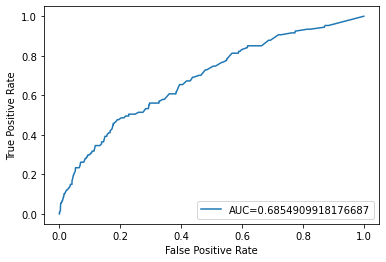

In [6]:
from sklearn import metrics
from matplotlib import pyplot as plt
y_pred_proba = our_rf_model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

# LIME

In [7]:
# Import for LIME
import lime
import lime.lime_tabular

file_to_be_explained = 'lucene/contrib/queryparser/src/java/org/apache/lucene/queryParser/standard/parser/StandardSyntaxParser.java'

print(f'Explaining {file_to_be_explained} with LIME')

Explaining lucene/contrib/queryparser/src/java/org/apache/lucene/queryParser/standard/parser/StandardSyntaxParser.java with LIME


In [9]:
# LIME Step 1 - Construct an explainer
our_lime_explainer = lime.lime_tabular.LimeTabularExplainer(
                            training_data = X_train.values,  
                            mode = 'classification',
                            training_labels = y_train,
                            feature_names = features,
                            class_names = class_labels,
                            discretize_continuous = True)
                            
# LIME Step 2 - Use the constructed explainer with the predict function 
# of your predictive model to explain any instance
lime_local_explanation_of_an_instance = our_lime_explainer.explain_instance(
                           # X_test[0],
                          # data_row = X_test.loc['FileName.py', : ], 
                            data_row = X_test.loc[file_to_be_explained, : ],
                            predict_fn = our_rf_model.predict_proba, 
                            num_features = 10,
                            top_labels = 1)

#explainer = lime_tabular.LimeTabularExplainer(X_train, mode = "regression", feature_names = boston_housing.feature_names)
#explanation = explainer.explain_instance(X_test[0], model.predict, num_features = len(boston_housing.feature_names))
                            
# Please use the code below to visualise the generated LIME explanation.
lime_local_explanation_of_an_instance.show_in_notebook()

/Users/saumenduroy/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


# SHAP

In [10]:
# Import libraries for SHAP
import subprocess
import sys
import importlib
import numpy
import shap

file_to_be_explained = 'lucene/contrib/queryparser/src/java/org/apache/lucene/queryParser/standard/parser/StandardSyntaxParser.java'
file_to_be_explained_idx = list(X_test.index).index(file_to_be_explained)

In [11]:
# explainer = shap.Explainer(our_rf_model, numpy.ascontiguousarray(X_train))
# shap_values = explainer(numpy.ascontiguousarray(X_test))

explainer = shap.Explainer(our_rf_model)
shap_values = explainer(X_test)

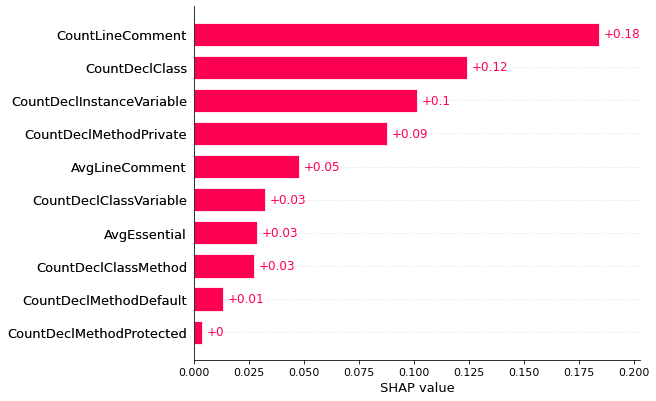

In [12]:
import matplotlib.pyplot as plt
shap.plots.bar(shap_values[file_to_be_explained_idx, :, 1], show=True)

# BreakDown

In [13]:
## Load Data and preparing datasets

# Import for Load Data
from os import listdir
from os.path import isfile, join
import pandas as pd

# Import for Split Data into Training and Testing Samples
from sklearn.model_selection import train_test_split

train_dataset = pd.read_csv(('/Users/saumenduroy/Documents/PhD Life/Explainability + SOAR/Explainers code/Best datset_model perspective_AUC/Data/lucene-2.9.0.csv'), index_col = 'File')
test_dataset = pd.read_csv(('/Users/saumenduroy/Documents/PhD Life/Explainability + SOAR/Explainers code/Best datset_model perspective_AUC/Data/lucene-3.1.csv'), index_col = 'File')


outcome = 'RealBug'
features = ['CountDeclMethodPrivate', 'CountDeclMethodDefault', 'AvgEssential','CountDeclClassVariable', 'CountDeclClassMethod', 'AvgLineComment', 'CountLineComment', 'CountDeclClass', 'CountDeclMethodProtected', 'CountDeclInstanceVariable']
# commits - # of commits that modify the file of interest
# Added lines - # of added lines of code
# Count class coupled - # of classes that interact or couple with the class of interest
# LOC - # of lines of code
# RatioCommentToCode - The ratio of lines of comments to lines of code

# process outcome to 0 and 1
train_dataset[outcome] = pd.Categorical(train_dataset[outcome])
train_dataset[outcome] = train_dataset[outcome].cat.codes

test_dataset[outcome] = pd.Categorical(test_dataset[outcome])
test_dataset[outcome] = test_dataset[outcome].cat.codes

X_train = train_dataset.loc[:, features]
X_test = test_dataset.loc[:, features]

y_train = train_dataset.loc[:, outcome]
y_test = test_dataset.loc[:, outcome]

class_labels = ['Clean', 'Defective']

X_train.columns = features
X_test.columns = features
training_data = pd.concat([X_train, y_train], axis=1)
testing_data = pd.concat([X_test, y_test], axis=1)

In [14]:
from sklearn.ensemble import RandomForestClassifier
our_rf_model = RandomForestClassifier(random_state=0)
our_rf_model.fit(X_train, y_train) 

RandomForestClassifier(random_state=0)

In [15]:
#necessary imports
from pyBreakDown.explainer import Explainer
from pyBreakDown.explanation import Explanation
#make explainer object
exp = Explainer(clf=our_rf_model, data= X_train, colnames=features)

In [16]:
#make explanation object that contains all information

explanation = exp.explain(observation=X_train.iloc[0,:].values,direction="up",useIntercept=True)

X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassif

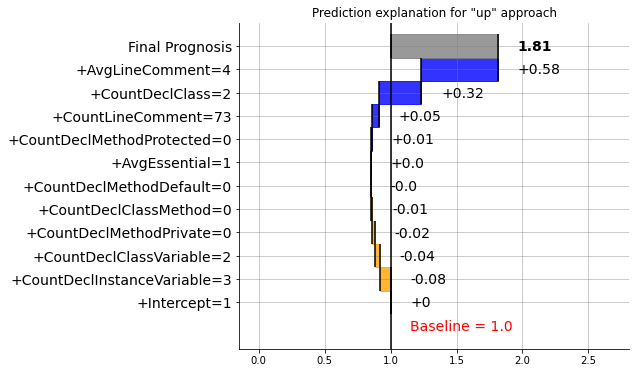

In [17]:
explanation.visualize()

# PyExplainer

In [18]:
## Load Data and preparing datasets

# Import for Load Data
from os import listdir
from os.path import isfile, join
import pandas as pd

# Import for Split Data into Training and Testing Samples
from sklearn.model_selection import train_test_split

train_dataset = pd.read_csv(('/Users/saumenduroy/Documents/PhD Life/Explainability + SOAR/Explainers code/Best datset_model perspective_AUC/Data/lucene-2.9.0.csv'), index_col = 'File')
test_dataset = pd.read_csv(('/Users/saumenduroy/Documents/PhD Life/Explainability + SOAR/Explainers code/Best datset_model perspective_AUC/Data/lucene-3.1.csv'), index_col = 'File')

outcome = 'RealBug'
features = ['CountDeclMethodPrivate', 'CountDeclMethodDefault', 'AvgEssential', 'CountDeclClassVariable', 'CountDeclClassMethod', 'AvgLineComment', 'CountLineComment', 'CountDeclClass', 'CountDeclMethodProtected', 'CountDeclInstanceVariable']
# OWN_COMMIT - # code ownership
# Added lines - # of added lines of code
# Count class coupled - # of classes that interact or couple with the class of interest
# RatioCommentToCode - The ratio of lines of comments to lines of code

# process outcome to 0 and 1
train_dataset[outcome] = pd.Categorical(train_dataset[outcome])
train_dataset[outcome] = train_dataset[outcome].cat.codes

test_dataset[outcome] = pd.Categorical(test_dataset[outcome])
test_dataset[outcome] = test_dataset[outcome].cat.codes

X_train = train_dataset.loc[:, features]
X_test = test_dataset.loc[:, features]

y_train = train_dataset.loc[:, outcome]
y_test = test_dataset.loc[:, outcome]


class_labels = ['Clean', 'Defective']

X_train.columns = features
X_test.columns = features
training_data = pd.concat([X_train, y_train], axis=1)
testing_data = pd.concat([X_test, y_test], axis=1)

In [19]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(random_state=0)
rf_model.fit(X_train, y_train)  

RandomForestClassifier(random_state=0)

In [20]:
from pyexplainer.pyexplainer_pyexplainer import PyExplainer
file_to_be_explained = 'lucene/contrib/queryparser/src/java/org/apache/lucene/queryParser/standard/parser/StandardSyntaxParser.java'
import numpy as np
np.random.seed(0)

pyexp = PyExplainer(X_train = X_train,
                           y_train = y_train,
                           indep = X_train.columns,
                           dep = outcome,
                           blackbox_model = rf_model)

# PyExplainer Step 2 - Generate the rule-based explanation of an instance to be explained
exp_obj = pyexp.explain(X_explain = X_test.loc[file_to_be_explained,:].to_frame().transpose(),
                        y_explain = pd.Series(bool(y_test.loc[file_to_be_explained]), 
                                                      index = [file_to_be_explained],
                                                      name = outcome),
                        search_function = 'crossoverinterpolation',
                        max_iter=1000,
                        max_rules=200,
                        random_state=0,
                        reuse_local_model=True)

# Print rule 
exp_obj['top_k_positive_rules'][:1]

# Please use the code below to visualise the generated PyExplainer explanation (What-If interactive visualisation).
pyexp.visualise(exp_obj, title="Why this file is predicted as defect-introducing?")


Output(layout=Layout(border='3px solid black'))

FloatSlider(value=9.0, continuous_update=False, description='#1 The value of CountDeclMethodPrivate is less th…

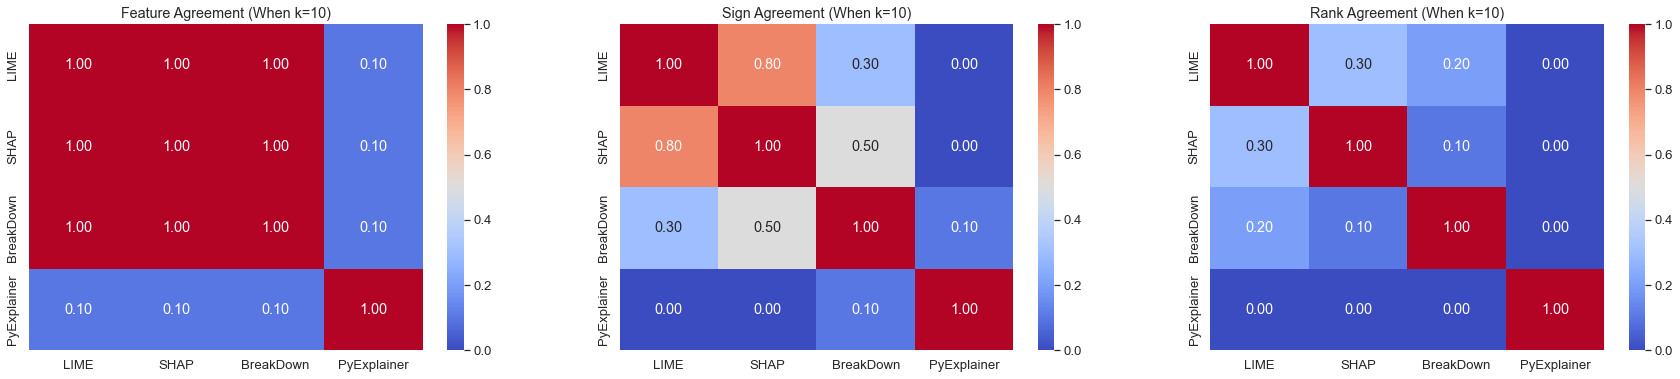

In [37]:
import seaborn as sns
import pandas as pd

data1 = pd.read_csv("/Users/saumenduroy/Desktop/TOSEM_replicationpackage/Feature Engineering_selection/Autospearman/k=10/A_Feature Agreement.csv", index_col=0)
data2 = pd.read_csv("/Users/saumenduroy/Desktop/TOSEM_replicationpackage/Feature Engineering_selection/Autospearman/k=10/A_Sign Agreement.csv", index_col=0)
data3 = pd.read_csv("/Users/saumenduroy/Desktop/TOSEM_replicationpackage/Feature Engineering_selection/Autospearman/k=10/A_Rank Agreement.csv", index_col=0)


fig, ax = plt.subplots(1,3, figsize=(30, 6))


sns.set(font_scale=1.2)
sns.heatmap(data1, cmap="coolwarm", annot=True, fmt=".2f", vmin=0, vmax=1, ax= ax[0])
ax[0].title.set_text("Feature Agreement (When k=10)")

sns.heatmap(data2, cmap="coolwarm", annot=True, fmt=".2f", vmin=0, vmax=1, ax= ax[1])
ax[1].title.set_text("Sign Agreement (When k=10)")

sns.heatmap(data3, cmap="coolwarm", annot=True, fmt=".2f", vmin=0, vmax=1, ax= ax[2])
ax[2].title.set_text("Rank Agreement (When k=10)")


plt.show()